In [1]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from umap import UMAP
import matplotlib.pyplot as plt
from clustering import *
from hdbscan import HDBSCAN

/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_small = "data/small_df/cleaned_small.csv"
data_avg = "data/average_df/cleaned_avg.csv"
data_tot = "data/total_df/cleaned_tot.csv"

df = pd.read_csv(data_tot)

corpus = df["cleaned_corpus"].tolist()
custom_stopwords = {
    "shaft", "plate", "member", "frame", "lever", "arm", "bar",
    "valve", "spring", "wheel", "machine", "rod", "pipe",
    "cylinder", "tube", "casing", "chamber", "head", "body"
}

corpus_cleaned = [delete_stopwords(text, custom_stopwords) for text in corpus]
corpus_cleaned = [patent.split() for patent in corpus_cleaned]

https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html#umap

#### **EMBEDDING MODELS**

BERTopic starts with transforming our input documents into numerical representations. Although there are many ways this can be achieved, we typically use sentence-transformers ("all-MiniLM-L6-v2") as it is quite capable of capturing the semantic similarity between documents.

**allenai-specter**
- Trained specifically on scientific papers using citation-based contrastive learning.
- Captures deep topical similarity — great for patent use cases.
- Input is typically abstracts/full paragraphs, so longer inputs are OK.
- Highly recommended if you’re doing semantic clustering or topic modeling.

https://huggingface.co/spaces/mteb/leaderboard
FOR BEST EMBEDDING MODELS AS OF NOW

In [3]:
embedding_model = SentenceTransformer("allenai-specter")
embeddings = embedding_model.encode(corpus_cleaned)

##### For custom embeddings:

When documents are too specific for a general pre-trained model to be used. 

#### **DIMENSIONALITY REDUCTION**

An important aspect of BERTopic is the dimensionality reduction of the input embeddings. As embeddings are often high in dimensionality, clustering becomes difficult due to the curse of dimensionality.

A solution is to reduce the dimensionality of the embeddings to a workable dimensional space (e.g., 5) for clustering algorithms to work with. UMAP is used as a default in BERTopic since it can capture both the local and global high-dimensional space in lower dimensions. However, there are other solutions out there, such as PCA that users might be interested in trying out.

NEED TO OPTIMIZE THE PARAMETERS FOR EACH ; could be interesting to look at the proposed solution from : https://medium.com/@boorism/inter-class-clustering-of-text-data-using-dimensionality-reduction-and-bert-390a5f9954b8


##### UMAP

As a default, BERTopic uses UMAP to perform its dimensionality reduction. To use a UMAP model with custom parameters, we simply define it and pass it to BERTopic:

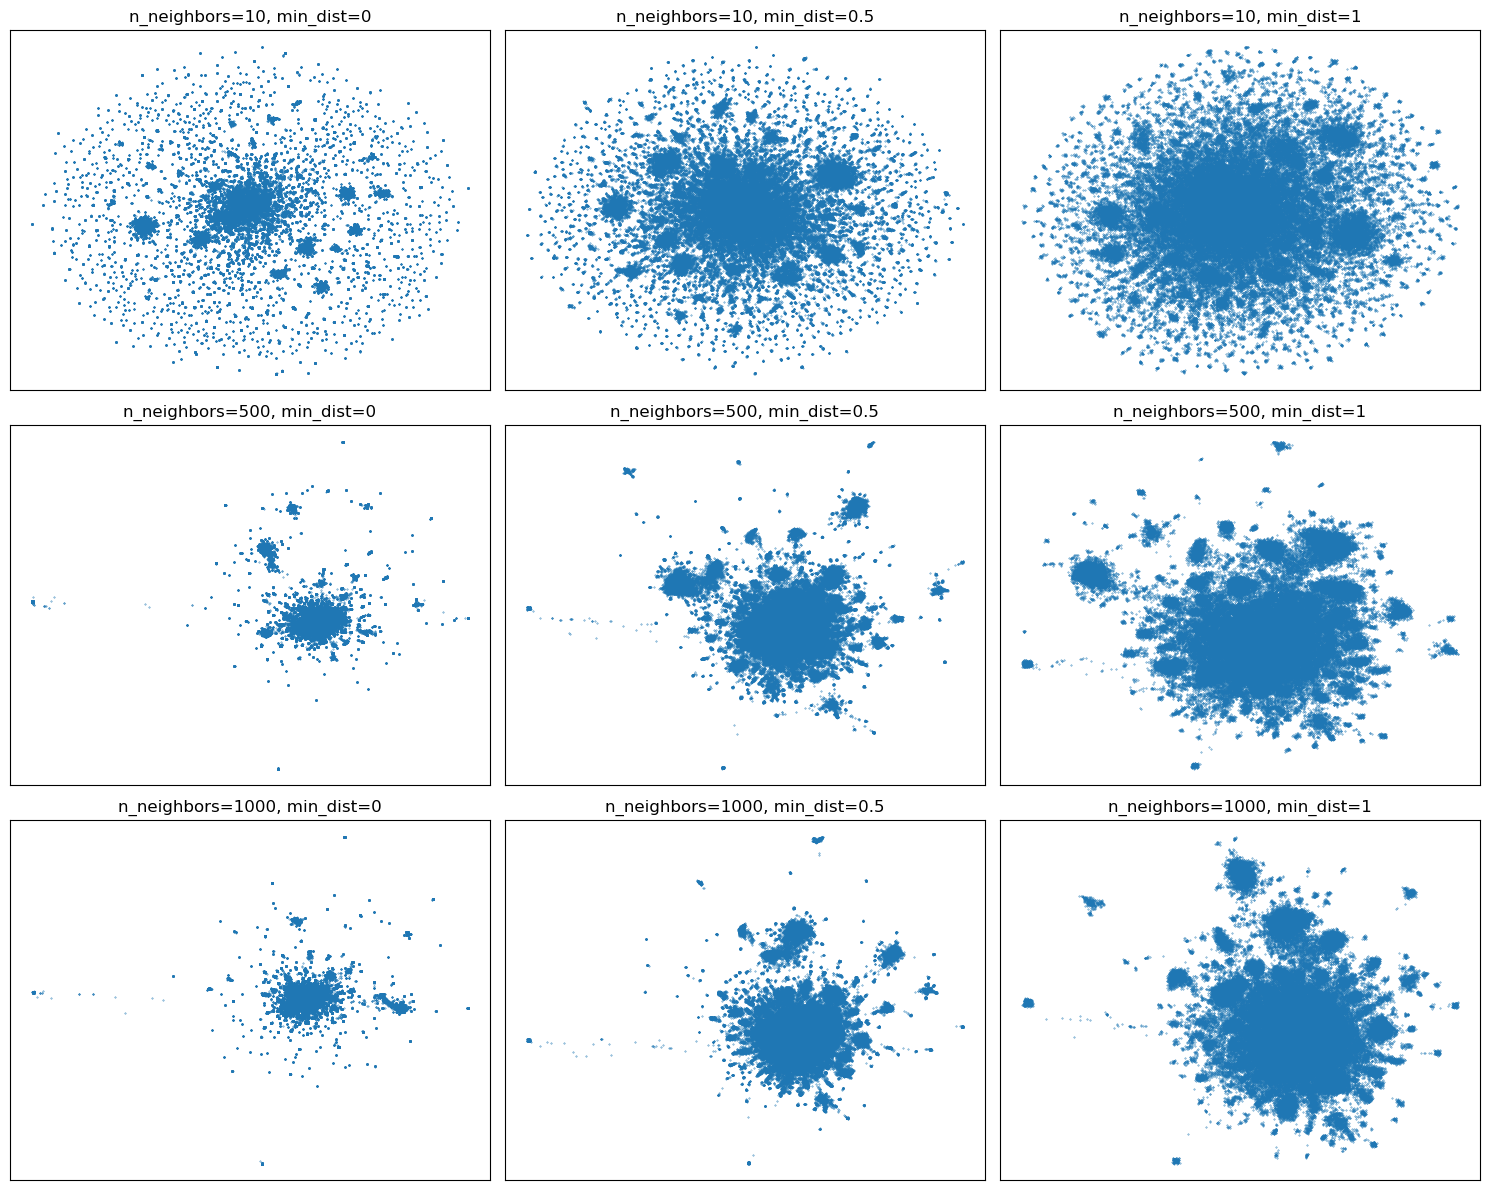

In [4]:
n_neighbors_list = [10, 500, 1000]
min_dist_list = [0, 0.5, 1]

fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 12))

for i, n_neighbors in enumerate(n_neighbors_list):
    for j, min_dist in enumerate(min_dist_list):
        ax = axes[i, j]
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                            n_components=2, random_state=42)
        X_umap = reducer.fit_transform(embeddings)
        sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=0.1, cmap='Spectral')
        ax.set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

In my opinion, there are two combinations which seem pretty good : (500,0) and (10, 0.5)

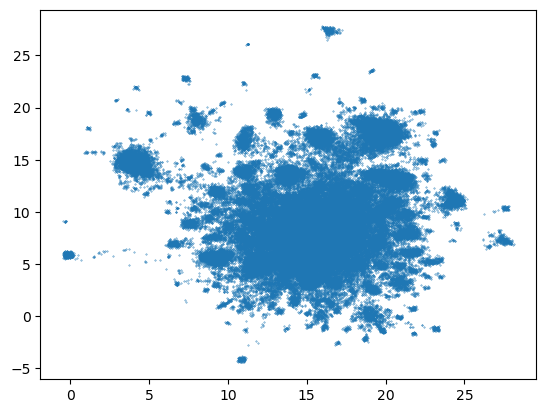

In [12]:
X_umap = umap.UMAP(n_neighbors = 500, min_dist = 1, n_components = 2, random_state=42).fit_transform(embeddings)
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=0.1, cmap='Spectral')

#### **CLUSTERING**

After reducing the dimensionality of our input embeddings, we need to cluster them into groups of similar embeddings to extract our topics. This process of clustering is quite important because the more performant our clustering technique the more accurate our topic representations are.

In BERTopic, we typically use HDBSCAN as it is quite capable of capturing structures with different densities. However, there is not one perfect clustering model and you might want to be using something entirely different for your use case.

##### HDBSCAN

As a default, BERTopic uses HDBSCAN to perform its clustering. To use a HDBSCAN model with custom parameters, we simply define it and pass it to BERTopic:

ONCE AGAIN, NEED TO FINETUNE THE PARAMETERS BEFOREHAND

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

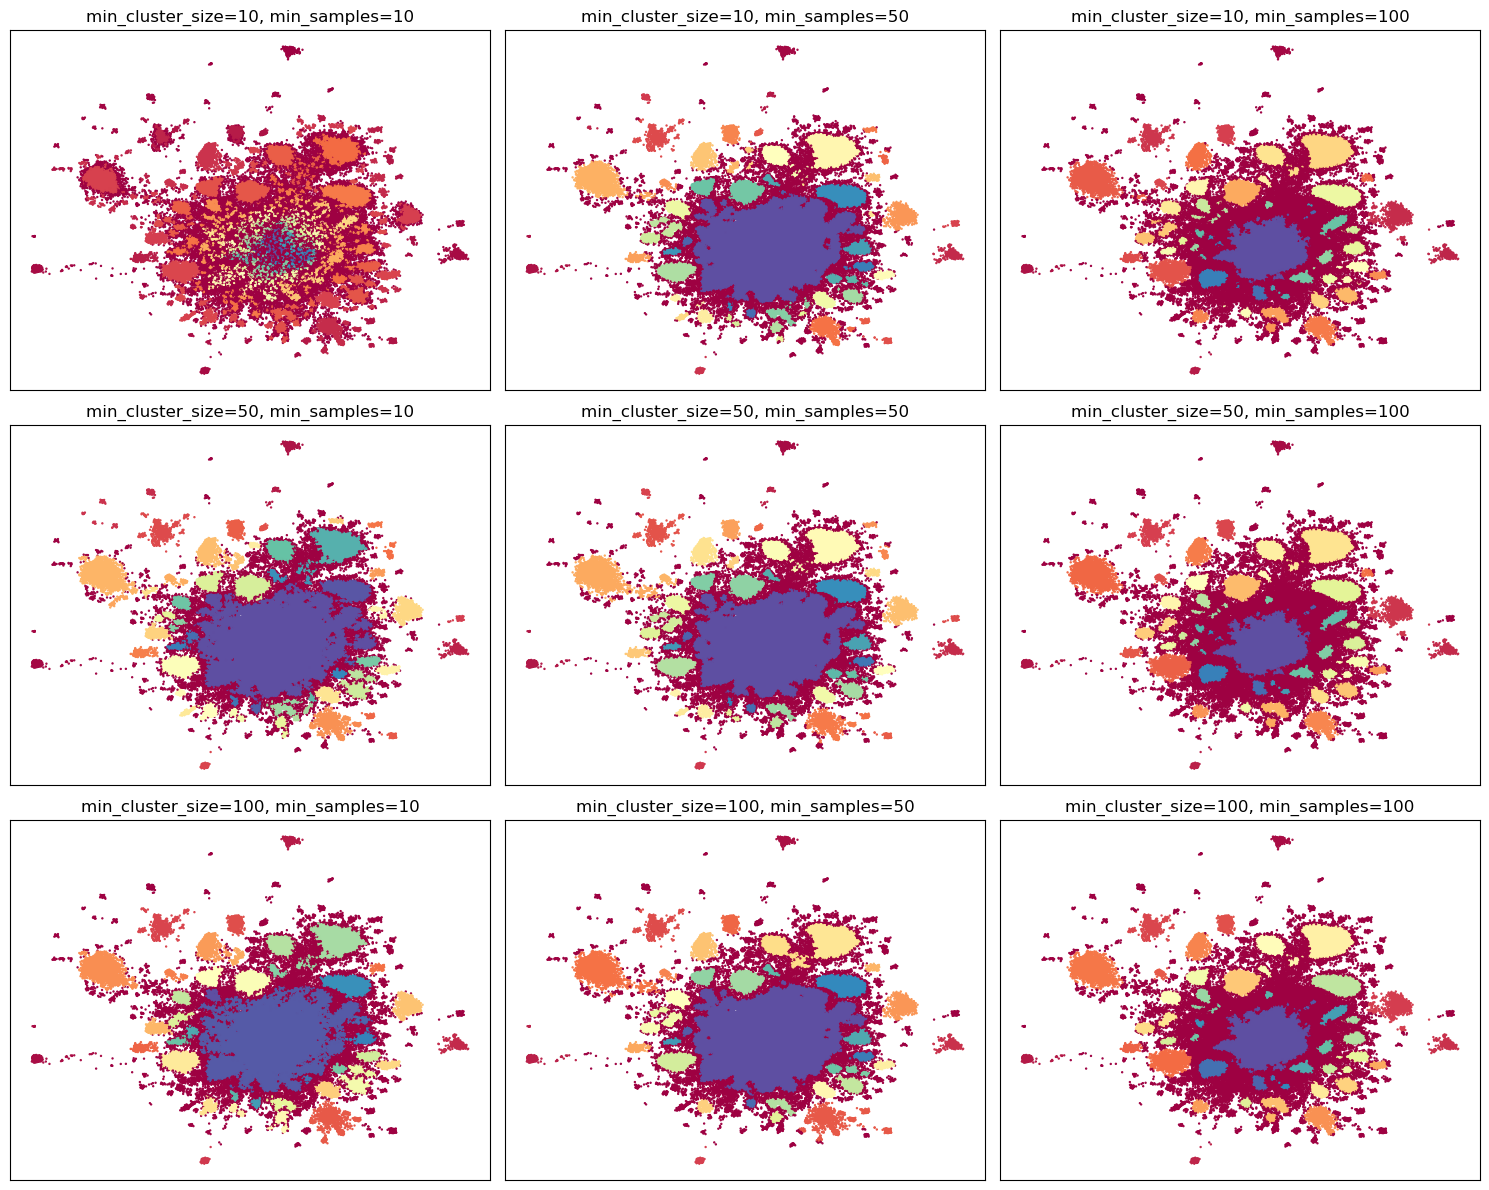

In [13]:
min_cluster_sizes = [10, 50, 100]
min_samples_list = [10, 50, 100]

fig, axes = plt.subplots(len(min_cluster_sizes), len(min_samples_list), figsize=(15, 12))

for i, min_cluster_size in enumerate(min_cluster_sizes):
    for j, min_samples in enumerate(min_samples_list):
        clusterer = HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples)
        labels = clusterer.fit_predict(X_umap)

        ax = axes[i, j]
        ax.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=0.5)
        ax.set_title(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import calinski_harabasz_score
def evaluate_hdbscan_ch(embeddings, min_cluster_sizes, min_samples_list):
    scores = np.zeros((len(min_cluster_sizes), len(min_samples_list)))

    for i, min_cluster_size in enumerate(min_cluster_sizes):
        for j, min_samples in enumerate(min_samples_list):
            clusterer = HDBSCAN(min_cluster_size=min_cluster_size,
                                        min_samples=min_samples)
            labels = clusterer.fit_predict(embeddings)

            mask = labels != -1
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if np.sum(mask) > 1 and n_clusters > 1:
                score = calinski_harabasz_score(embeddings[mask], labels[mask])
            else:
                score = 0  
            scores[i, j] = score
    return scores

**Calinski-Harabasz Score**
- $n$: total number of samples
- $k$: number of clusters
- $\mu$: overall centroid of the dataset
- $\mu_j$: centroid of cluster j
- $n_j$ : number of points in cluster j
- $x_i$ : data point

**Between-cluster dispersion**
This increases when clusters are far away from each other. 
$$
SS_B = \sum_{j=1}^k n_j||\mu_j - \mu||^2
$$

**Within-cluster dispersion**
This decreases when within cluster data points are close to each other. 
$$
SS_W = \sum_{j=1}^k \sum_{x_i \in C_j} ||x_i - \mu_j||^2
$$

**SCORE**
The optimal CH score is the highest possible. 
$$
CH = \frac{\text{Between-cluster dispersion}}{\text{Within-cluster dispersion}} . \frac{n-k}{k-1}
$$

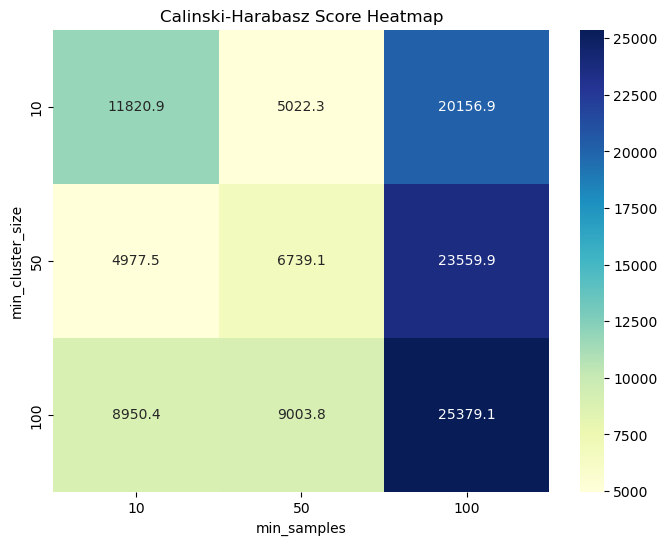

In [15]:
import seaborn as sns

# Evaluate scores
ch_scores = evaluate_hdbscan_ch(X_umap, min_cluster_sizes, min_samples_list)

plt.figure(figsize=(8, 6))
sns.heatmap(ch_scores, annot=True, fmt=".1f", cmap="YlGnBu",
            xticklabels=min_samples_list, yticklabels=min_cluster_sizes)
plt.xlabel("min_samples")
plt.ylabel("min_cluster_size")
plt.title("Calinski-Harabasz Score Heatmap")
plt.show()

Looking visually at the results it seems clear that the clustering with min_cluster_size of 100 is not optimal. Visually, it seems the best combination is 10, 50 which is kind of confirmed by the obtained score of 1600. 

In [21]:
hdbscan_model = HDBSCAN(min_cluster_size=100, min_samples=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

#### C-TFIDF

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def extract_top_n_words_per_topic(X, terms, top_n=10):
    words_per_topic = []
    for row in X:
        top_indices = row.toarray().flatten().argsort()[::-1][:top_n]
        top_words = [terms[i] for i in top_indices]
        words_per_topic.append(top_words)
    return words_per_topic

def get_topics(data):
    data = data[data['Cluster'] != -1]

    # Combine texts per cluster
    docs_per_topic = data.groupby('Cluster')['cleaned_corpus'].apply(lambda x: ' '.join(x)).tolist()  
    
    vectorizer = CountVectorizer(stop_words='english')
    X_counts = vectorizer.fit_transform(docs_per_topic)

    transformer = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True, sublinear_tf=False)
    X_ctfidf = transformer.fit_transform(X_counts)

    # Vocabulary
    terms = vectorizer.get_feature_names_out()

    top_words = extract_top_n_words_per_topic(X_ctfidf, terms, top_n=10)

    dict_topic = {}
    # Print topics
    for i, words in enumerate(top_words):
        print(f"Topic {i}: {', '.join(words)}")
        dict_topic[i] = {', '.join(words)}
    return dict_topic

In [23]:
df_copy = df.copy()
labels_hdbscan = hdbscan_model.fit_predict(X_umap)
df_copy["Cluster"] = labels_hdbscan

topics = get_topics(df_copy)
topics 

Topic 0: shaft, arm, machine, plate, lever, frame, spring, mechanism, mounted, wheel
Topic 1: member, casing, body, arm, spring, nited, frame, plate, lever, valve
Topic 2: shaft, plate, valve, mechanism, member, arm, lever, frame, mounted, diecase
Topic 3: valve, shaft, lever, arm, frame, pipe, plate, spring, passage, material
Topic 4: shaft, member, plate, frame, bar, spring, arm, lever, machine, wheel
Topic 5: shaft, lever, frame, andrew, plate, member, arm, bar, valve, spring
Topic 6: shaft, lever, plate, arm, frame, machine, bar, mechanism, spring, rod
Topic 7: shaft, member, frame, valve, plate, arm, lever, eugene, pipe, machine
Topic 8: shaft, machine, plate, member, lever, bar, spring, frame, arm, mechanism
Topic 9: member, frame, shaft, mechanism, bar, lever, clutch, mounted, victor, valve
Topic 10: shaft, plate, arm, member, james, frame, lever, spring, bar, machine
Topic 11: member, shaft, plate, lever, frame, arm, spring, bar, machine, mechanism
Topic 12: plate, rollback, ar

{0: {'shaft, arm, machine, plate, lever, frame, spring, mechanism, mounted, wheel'},
 1: {'member, casing, body, arm, spring, nited, frame, plate, lever, valve'},
 2: {'shaft, plate, valve, mechanism, member, arm, lever, frame, mounted, diecase'},
 3: {'valve, shaft, lever, arm, frame, pipe, plate, spring, passage, material'},
 4: {'shaft, member, plate, frame, bar, spring, arm, lever, machine, wheel'},
 5: {'shaft, lever, frame, andrew, plate, member, arm, bar, valve, spring'},
 6: {'shaft, lever, plate, arm, frame, machine, bar, mechanism, spring, rod'},
 7: {'shaft, member, frame, valve, plate, arm, lever, eugene, pipe, machine'},
 8: {'shaft, machine, plate, member, lever, bar, spring, frame, arm, mechanism'},
 9: {'member, frame, shaft, mechanism, bar, lever, clutch, mounted, victor, valve'},
 10: {'shaft, plate, arm, member, james, frame, lever, spring, bar, machine'},
 11: {'member, shaft, plate, lever, frame, arm, spring, bar, machine, mechanism'},
 12: {'plate, rollback, arm, 